In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'utkface-new:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F44109%2F78156%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240317%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240317T010915Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1d28c4678b6b34873d14065b06078016f775677ebb87ea79180ae1be3a9dc2a380c48b153b998170d55ab9c8cd7fbd510b595c8bb3c409d28a4225b7e59f34ef4e1be7df95b9fa624de878da361ad7f53931f3d4714b1582b69a181ff6c28841316cc2484dc0ccc3430db7982b129a4462d508fe25eebf75ffd19ef390d92e4d0b2c6f19741726e41550b384669db06bbd8148b415ecf6ad52858e61a6e3d077d3b5883e5c6f992f58605e3bdd35447843ff70bb372c5856b7acf5d254d6a00308415b8820da6e99d8104c9dc773af358f457917451504c84905a06e1df7aff3e4b22809198441c7dba6130750685572369783a5e49e51ad430956bfb8beb0c1,eddys-training-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4603459%2F7850110%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240317%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240317T010915Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D68a948c434852297c1cede4f620dc4f953554ba112355e990282ac8572408403310584d97fb2f04f47fb3ad9bf618aa04a25b2bb7dd6780fa95d1c5838a3036fabc5efb95d0799ac13e0fc36d14c91df3b62c368e1e08b682f6d6765594ace2126d621eedd4df89b1614e056f5882df502a41f7060e8d7f910c821164e4ddc5f018d54db2e09491b687c4886670b9268e4dffcb1190649acbc3c4ed99516bdf96a39daf67f81163102d9cc2186d6d45365d4fd2489ff77190e3c26695b42229dfc19716ce35a368c4a4c66ff7d78c2299d18d53b97c75fd3251ce9b25d322032f37903bf3d0c76173515cfbf472691ebc606199e6d9fb4468c8ff8b1f43087fd'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 347342542 bytes downloaded
Downloaded and uncompressed: utkface-new
[==================================================] 189214702 bytes downloaded
Downloaded and uncompressed: eddys-training-data
Data source import complete.


In [2]:
!pip install vit-keras
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 14.3 MB/s eta 0:00:00


In [3]:
import warnings
warnings.filterwarnings(action="ignore")
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import os
import tensorflow as tf
from vit_keras import vit
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gender_transformer_model = vit.vit_b16(include_top=True,
                                       pretrained = True,
                                       image_size=(224, 224),
                                       classes=2,
                                       activation="sigmoid",
                                       pretrained_top=False,
                                       weights = "imagenet21k+imagenet2012")

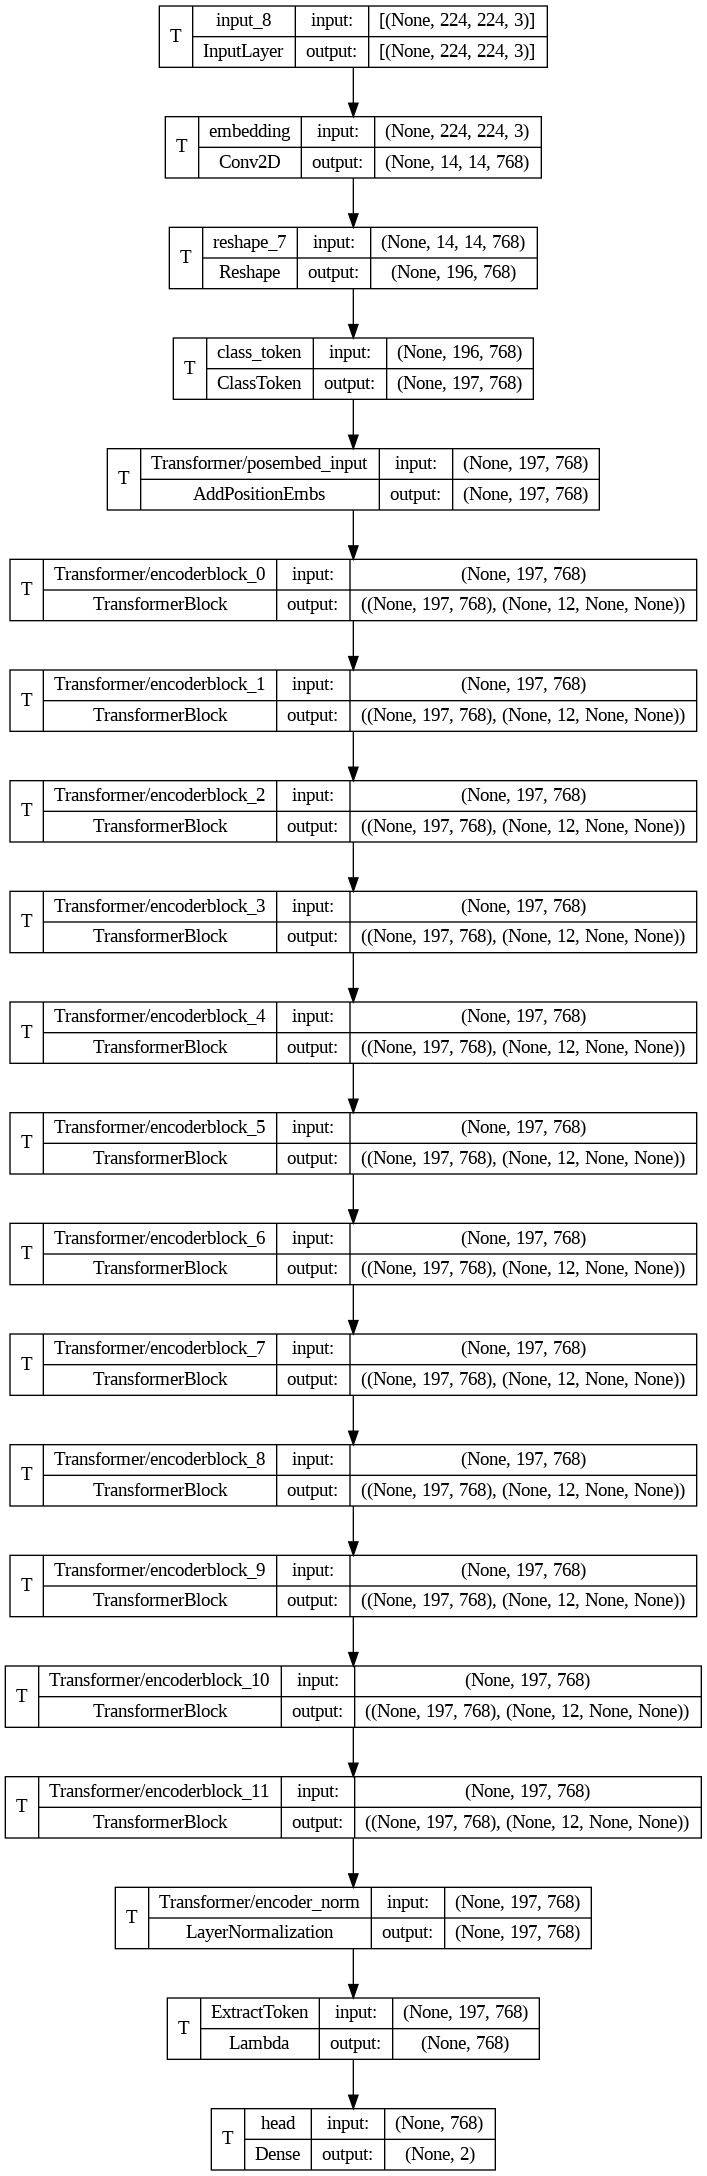

In [ ]:
tf.keras.utils.plot_model(gender_transformer_model, show_trainable=True, show_shapes=True)

In [ ]:
gender_image_gen_train = ImageDataGenerator(preprocessing_function=vit.preprocess_inputs, horizontal_flip=True)
gender_image_gen_test = ImageDataGenerator(preprocessing_function=vit.preprocess_inputs)

In [ ]:
data_dir = "/kaggle/input/eddys-training-data/Gender-20240315T080440Z-001/Gender"

data = {"images":[], "labels":[]}
for gender in os.listdir(data_dir):
  dir_1 = os.path.join(data_dir, gender)
  for dir_2 in os.listdir(dir_1):
    dir_3 = os.path.join(dir_1, dir_2)
    data["images"].append(dir_3)
    data["labels"].append(gender)

gender_data = pd.DataFrame(data)

print(gender_data.shape)

gender_data.head()

(14286, 2)


,images,labels
0,/kaggle/input/eddys-training-data/Gender-20240...,Female
1,/kaggle/input/eddys-training-data/Gender-20240...,Female
2,/kaggle/input/eddys-training-data/Gender-20240...,Female
3,/kaggle/input/eddys-training-data/Gender-20240...,Female
4,/kaggle/input/eddys-training-data/Gender-20240...,Female


In [ ]:
Xtrain_gender, Xtest_gender, ytrain_gender, ytest_gender = train_test_split(gender_data["images"],
                                                                            gender_data["labels"],
                                                                            test_size=0.2,
                                                                            stratify=gender_data["labels"])

In [ ]:
gender_train = pd.concat([Xtrain_gender, ytrain_gender], axis=1)

gender_test = pd.concat([Xtest_gender, ytest_gender], axis=1)

In [ ]:
gender_train_gen = gender_image_gen_train.flow_from_dataframe(dataframe=gender_train,
                                                              x_col="images",
                                                              y_col="labels",
                                                              target_size=(224, 224),
                                                              class_mode="binary")

gender_test_gen = gender_image_gen_test.flow_from_dataframe(dataframe=gender_test,
                                                            x_col="images",
                                                            y_col="labels",
                                                            target_size=(224, 224),
                                                            class_mode="binary")

Found 11428 validated image filenames belonging to 2 classes.

Found 2858 validated image filenames belonging to 2 classes.


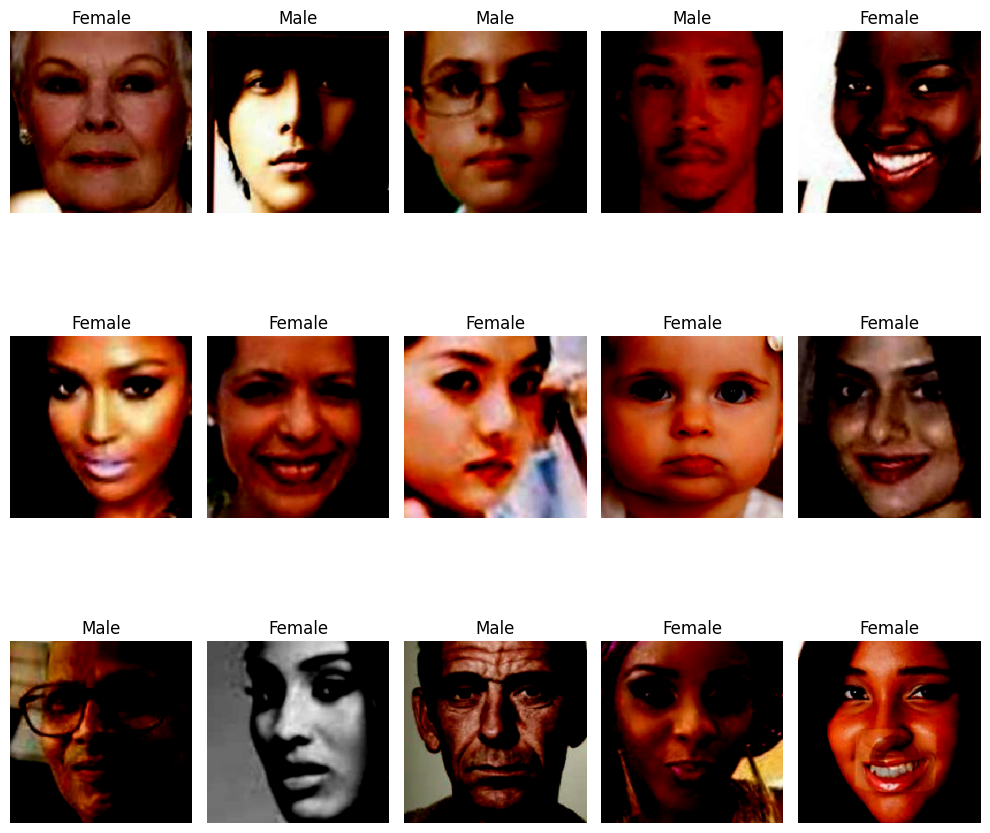

In [ ]:
images = [gender_train_gen[0][0][i] for i in range(16)]
labels = [gender_train_gen[0][1][i] for i in range(16)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax, label in zip(images, axes, labels):
    ax.imshow(img)
    ax.set_title({j:i for i, j in gender_train_gen.class_indices.items()}[label])
    ax.axis('off')

plt.tight_layout()
plt.show()

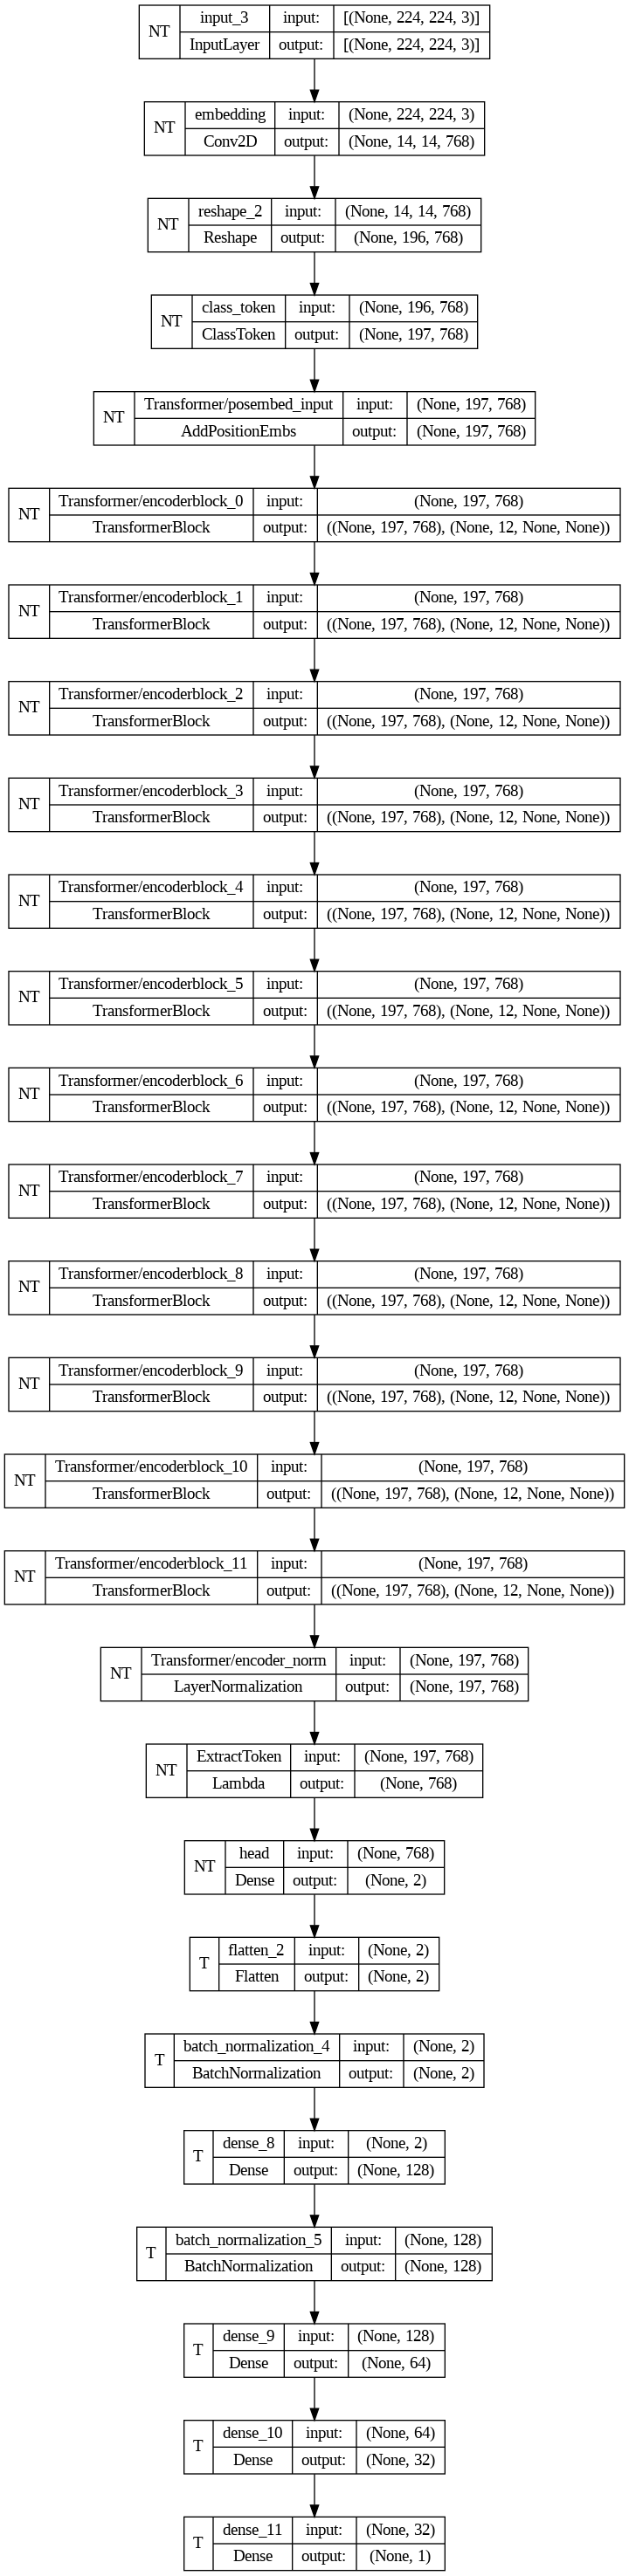

In [ ]:
gender_model_output = gender_transformer_model.output
x = keras.layers.Flatten()(gender_model_output)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation = tfa.activations.gelu)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation = tfa.activations.gelu)(x)
x = keras.layers.Dense(32, activation = tfa.activations.gelu)(x)
output = keras.layers.Dense(1, 'sigmoid')(x)

gender_model = keras.Model(inputs=gender_transformer_model.input, outputs=output)

tf.keras.utils.plot_model(gender_model, show_trainable=True, show_shapes=True)

In [ ]:
gender_model.compile(optimizer=tfa.optimizers.RectifiedAdam(learning_rate=1e-4), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
gender_transformer_model.trainable = False

In [ ]:
gender_model.fit(gender_train_gen,
                 validation_data=gender_test_gen,
                 epochs=10,
                 callbacks=[keras.callbacks.EarlyStopping(patience=5),
                            keras.callbacks.ReduceLROnPlateau(patience=2),
                            keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/Projects/Data science projects/model/gender_model.h5",
                                                            save_best_only=True)])

Epoch 1/10

358/358 [==============================] - 243s 642ms/step - loss: 0.6673 - accuracy: 0.5839 - val_loss: 0.4285 - val_accuracy: 0.9622 - lr: 1.0000e-04

Epoch 2/10

358/358 [==============================] - 216s 604ms/step - loss: 0.1646 - accuracy: 0.9517 - val_loss: 0.1061 - val_accuracy: 0.9640 - lr: 1.0000e-04

Epoch 3/10

358/358 [==============================] - 216s 604ms/step - loss: 0.1397 - accuracy: 0.9520 - val_loss: 0.1012 - val_accuracy: 0.9647 - lr: 1.0000e-04

Epoch 4/10

358/358 [==============================] - 220s 614ms/step - loss: 0.1369 - accuracy: 0.9515 - val_loss: 0.1009 - val_accuracy: 0.9643 - lr: 1.0000e-04

Epoch 5/10

358/358 [==============================] - 213s 596ms/step - loss: 0.1367 - accuracy: 0.9545 - val_loss: 0.1009 - val_accuracy: 0.9643 - lr: 1.0000e-04

Epoch 6/10

358/358 [==============================] - 212s 591ms/step - loss: 0.1330 - accuracy: 0.9540 - val_loss: 0.1010 - val_accuracy: 0.9643 - lr: 1.0000e-04

Epoch 7/10

In [ ]:
gender_training_history = pd.DataFrame(gender_model.history.history)

gender_training_history.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,0.667347,0.583917,0.428492,0.962211,0.0001
1,0.164589,0.951698,0.106093,0.963961,0.0001
2,0.139695,0.951960,0.101227,0.964661,0.0001
3,0.136886,0.951523,0.100925,0.964311,0.0001
4,0.136682,0.954498,0.100904,0.964311,0.0001


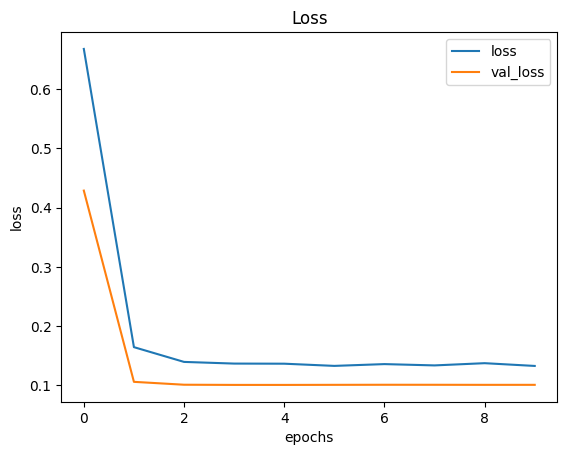

In [ ]:
gender_training_history[["loss", "val_loss"]].plot(title="Loss", xlabel="epochs", ylabel="loss")
plt.show()

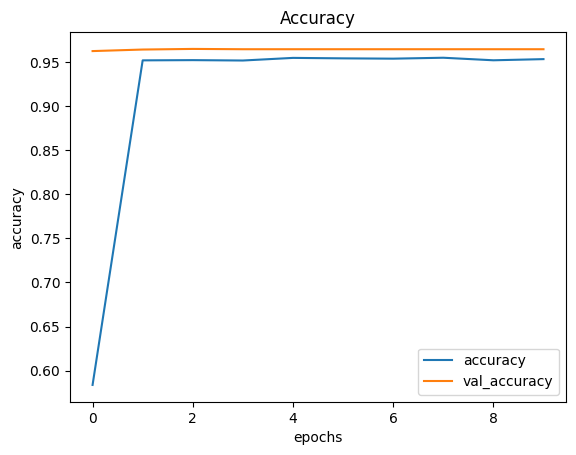

In [ ]:
gender_training_history[["accuracy", "val_accuracy"]].plot(title="Accuracy", xlabel="epochs", ylabel="accuracy")
plt.show()

In [ ]:
!pip install transformers

In [5]:
age_dir = "/kaggle/input/utkface-new/UTKFace"

data = {"images":[], "age":[]}
for dir_1 in os.listdir(age_dir):
    data["images"].append(os.path.join(age_dir, dir_1))
    data["age"].append(dir_1.split("_")[0])

age_data = pd.DataFrame(data)

print(age_data.shape)

age_data.head()

(23708, 2)


,images,age
0,/kaggle/input/utkface-new/UTKFace/1_0_3_201612...,1
1,/kaggle/input/utkface-new/UTKFace/24_0_3_20170...,24
2,/kaggle/input/utkface-new/UTKFace/26_0_0_20170...,26
3,/kaggle/input/utkface-new/UTKFace/35_1_0_20170...,35
4,/kaggle/input/utkface-new/UTKFace/12_1_2_20170...,12


In [6]:
age_data["age"] = age_data["age"].astype("int")

In [7]:
age_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  23708 non-null  object
 1   age     23708 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 370.6+ KB


In [8]:
age_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,23708.0,33.303484,19.886112,1.0,23.0,29.0,45.0,116.0


<Figure size 1500x600 with 0 Axes>

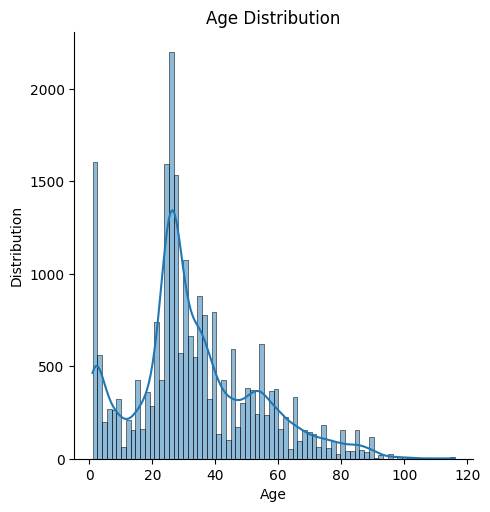

In [9]:
plt.figure(figsize=(15, 6))
sns.displot(age_data["age"], kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Distribution")
plt.show()

In [10]:
age_data["age_bin"] = pd.cut(age_data["age"],
                             bins=[1, 11, 21, 31, 41, 61, +np.inf],
                             labels=["1-10 years", "11-20 years", "21-30 years", "31-40 years", "41-60 years", "61 years and above"],
                             right=False)

<Axes: title={'center': 'Age Category Distribution'}, xlabel='Age Category', ylabel='Counts'>

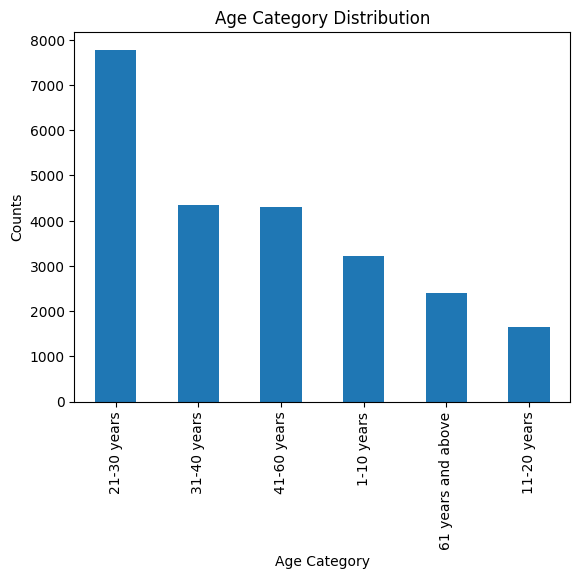

In [11]:
age_data["age_bin"].value_counts().plot(kind="bar",
                                        xlabel="Age Category",
                                        ylabel="Counts", title="Age Category Distribution")

In [12]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

over_sample = RandomOverSampler()
down_sample = RandomUnderSampler()

age_Xupsampled, age_yupsampled = over_sample.fit_resample(age_data[["images", "age"]], age_data["age_bin"])

age_Xdownsampled, age_ydownsampled = down_sample.fit_resample(age_data[["images", "age"]], age_data["age_bin"])

In [13]:
age_data_upsampled = pd.concat([age_Xupsampled, age_yupsampled], axis=1)

age_data_downsampled = pd.concat([age_Xdownsampled, age_ydownsampled], axis=1)

In [14]:
age_data_downsampled

,images,age,age_bin
0,/kaggle/input/utkface-new/UTKFace/3_0_0_201701...,3,1-10 years
1,/kaggle/input/utkface-new/UTKFace/9_0_0_201701...,9,1-10 years
2,/kaggle/input/utkface-new/UTKFace/3_1_2_201612...,3,1-10 years
3,/kaggle/input/utkface-new/UTKFace/1_1_0_201612...,1,1-10 years
4,/kaggle/input/utkface-new/UTKFace/2_0_3_201612...,2,1-10 years
...,...,...,...
9949,/kaggle/input/utkface-new/UTKFace/76_0_0_20170...,76,61 years and above
9950,/kaggle/input/utkface-new/UTKFace/63_0_3_20170...,63,61 years and above
9951,/kaggle/input/utkface-new/UTKFace/72_1_2_20170...,72,61 years and above
9952,/kaggle/input/utkface-new/UTKFace/74_0_0_20170...,74,61 years and above


In [15]:
age_Xtrain, age_Xtest, age_ytrain, age_ytest = train_test_split(age_data_downsampled["images"],
                                                                age_data_downsampled["age_bin"],
                                                                test_size=0.01)

In [16]:
age_train = pd.concat([age_Xtrain, age_ytrain], axis=1)

age_test = pd.concat([age_Xtest, age_ytest], axis=1)

In [17]:
print(age_train.shape, age_test.shape)

(9854, 2) (100, 2)


In [46]:
from transformers import ViTFeatureExtractor

image_processor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [49]:
age_train_generator = ImageDataGenerator(horizontal_flip=True,
                          preprocessing_function=lambda x: image_processor.preprocess(x, data_format="channels_last")["pixel_values"][0] #Didn't work as expected
                                         #preprocessing_function=vgg16.preprocess_input
)

age_test_generator = ImageDataGenerator(
          preprocessing_function=lambda x: image_processor.preprocess(x, data_format="channels_last")["pixel_values"][0]
           #preprocessing_function=vgg16.preprocess_input
          )

In [50]:
age_train_gen = age_train_generator.flow_from_dataframe(dataframe=age_train,
                                                        x_col="images",
                                                        y_col="age_bin",
                                                        class_mode="categorical",
                                                        target_size=(224, 224))

age_test_gen = age_test_generator.flow_from_dataframe(dataframe=age_test,
                                                      x_col="images",
                                                      y_col="age_bin",
                                                      class_mode="categorical",
                                                      target_size=(224, 224))

Found 9854 validated image filenames belonging to 6 classes.
Found 100 validated image filenames belonging to 6 classes.


In [51]:
preprocess_layer = keras.Sequential([
   keras.layers.Permute((3, 1, 2))
])

In [52]:
from transformers import  TFViTModel

base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [54]:
input_layer = keras.Input(shape=(224, 224, 3))
x = preprocess_layer(input_layer)
x = base_model.vit(x)[0][:, 0, :]
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation = tfa.activations.gelu)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation = tfa.activations.gelu)(x)
x = keras.layers.Dense(32, activation = tfa.activations.gelu)(x)
# You can add more layers
output = keras.layers.Dense(units=6, activation="softmax")(x)
age_model = keras.Model(inputs=input_layer, outputs=output)

In [55]:
age_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss="categorical_crossentropy", metrics=["accuracy"])

In [57]:
age_model.fit(age_train_gen,
              validation_data=age_test_gen,
              epochs=10 ,
              callbacks=[keras.callbacks.ReduceLROnPlateau(patience=2),
                         keras.callbacks.EarlyStopping(patience=5),
                        ])

Epoch 1/10
308/308 [==============================] - 159s 512ms/step - loss: 0.9689 - accuracy: 0.6259 - val_loss: 0.9218 - val_accuracy: 0.6300 - lr: 1.0000e-04
Epoch 2/10
308/308 [==============================] - 154s 499ms/step - loss: 0.8328 - accuracy: 0.6631 - val_loss: 0.8753 - val_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 3/10
308/308 [==============================] - 158s 511ms/step - loss: 0.7631 - accuracy: 0.6841 - val_loss: 0.8652 - val_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 4/10
308/308 [==============================] - 156s 506ms/step - loss: 0.7232 - accuracy: 0.6995 - val_loss: 0.8751 - val_accuracy: 0.6600 - lr: 1.0000e-04
Epoch 5/10
308/308 [==============================] - 155s 502ms/step - loss: 0.6966 - accuracy: 0.7133 - val_loss: 0.8878 - val_accuracy: 0.6100 - lr: 1.0000e-04
Epoch 6/10
308/308 [==============================] - 152s 494ms/step - loss: 0.6665 - accuracy: 0.7289 - val_loss: 0.8852 - val_accuracy: 0.6300 - lr: 1.0000e-05
Epoch 7/10
308/308 [==

In [58]:
age_training_history = pd.DataFrame(age_model.history.history)

age_training_history.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,0.968896,0.625939,0.921809,0.63,0.0001
1,0.832797,0.663081,0.875252,0.65,0.0001
2,0.763142,0.684088,0.865237,0.65,0.0001
3,0.723173,0.699513,0.875071,0.66,0.0001
4,0.696565,0.713314,0.887779,0.61,0.0001


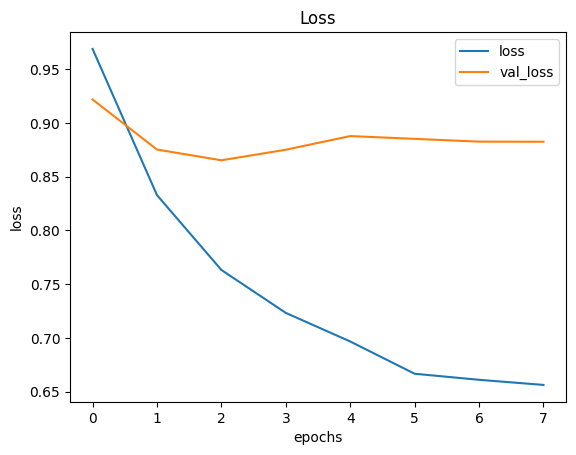

In [59]:
age_training_history[["loss", "val_loss"]].plot(title="Loss", xlabel="epochs", ylabel="loss")
plt.show()

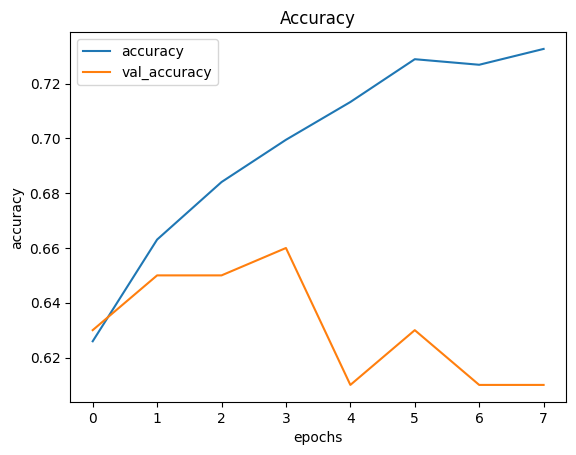

In [60]:
age_training_history[["accuracy", "val_accuracy"]].plot(title="Accuracy", xlabel="epochs", ylabel="accuracy")
plt.show()

## Eddy